(37, 5627) (37, 5618)
ElasticNet - R2 score: 0.6844917366937485
ElasticNet - MSE: 9.840790975006923
ElasticNet - RMSE: 3.1370035025493554
ElasticNet - MAE: 2.6815194500714132
GBR - R2 score: 0.45218232180522044
GBR - MSE: 17.08658659851213
GBR - RMSE: 4.133592456751407
GBR - MAE: 2.979536239374304


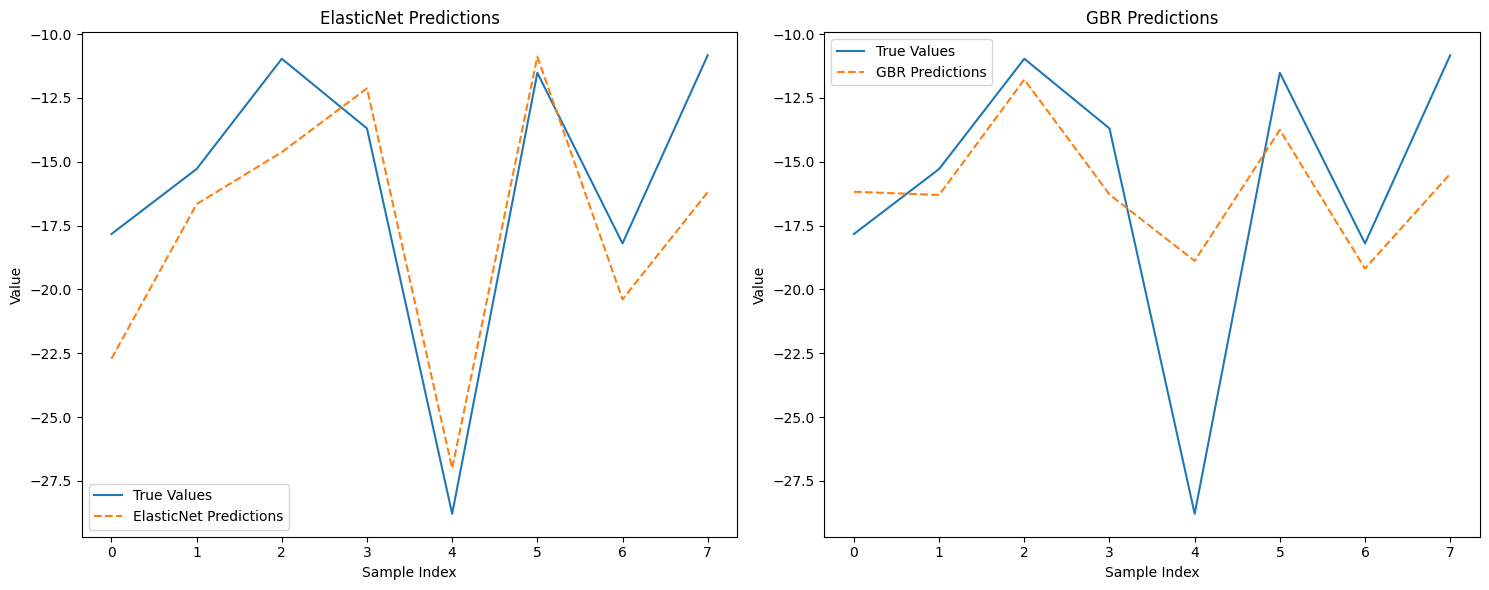

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Read data
file_path = 'EDCPCE-replace0toNan.xlsx'
df = pd.read_excel(file_path)

# preprocess data
df = df.drop(index=47)
df.iloc[:, 2].replace('ND', np.nan, inplace=True)
df.iloc[:, 2] = df.iloc[:, 2].astype(float)
df = df.dropna(subset=[df.columns[2]])

y = df.iloc[:, 2].values

X = df.iloc[:, 4:].values

imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
print(X.shape,X_imputed.shape)
df = df.dropna(axis=1, how='all')
df.iloc[:, 4:] = X_imputed

selected_feature_names1 = ['k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Eubacteriaceae; g__Acetobacterium; s__',
       'k__Bacteria; p__Acidobacteria; c__Solibacteres; o__Solibacterales; f__; g__; s__.3',
       'k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Nocardioidaceae; g__Aeromicrobium; s__.2',
       'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__EtOH8; g__; s__.1',
       'k__Bacteria; p__Firmicutes; c__Clostridia; o__Thermoanaerobacterales; f__Thermodesulfobiaceae; g__Thermodesulfobium; s__',
       'k__Bacteria; p__Proteobacteria; c__Deltaproteobacteria; o__Syntrophobacterales; f__Syntrophaceae; g__Desulfobacca; s__',
       'k__Archaea; p__[Parvarchaeota]; c__[Parvarchaea]; o__WCHD3-30; f__; g__; s__.27',
       'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Paludibacter; s__.4',
       'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptococcaceae; g__Desulfosporosinus; s__meridiei.20',
       'Unclassified.140',
       'k__Archaea; p__Euryarchaeota; c__Methanomicrobia; o__Methanomicrobiales; f__Methanoregulaceae; g__Candidatus Methanoregula; s__.5',
       'k__Bacteria; p__Spirochaetes; c__Spirochaetes; o__Spirochaetales; f__Spirochaetaceae; g__Treponema; s__.18',
       'k__Bacteria; p__NC10; c__12-24; o__JH-WHS47; f__; g__; s__.1', 'Iron',
       'Manganese', 'Sulphate', 'Methane', 'Ethane', 'Bacterial_gene_copies',
       'Archaeal_gene_copies', 'EC', 'Er', 'Temp', 'Chloride',
       '"1,1-dichloroethene"', 'Bromoform', '"cis-1,2-dichloroethene"',
       'Dibromomethane', 'Dichloromethane', 'Hexachlorobutadiene']

selected_feature_names2 = ['EC', 'Temp', 'Trichloroethene', '"cis-1,2-dichloroethene"', 'Sulphide', 
                           'Chloride', '"1,2-dichloroethane"', 'pH', 'Er', 'Vinyl chloride', 
                           'Chloroform', '"1,1,2-trichloroethane"']

X1 = df[selected_feature_names1].values
X2 = df[selected_feature_names2].values

scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# split data
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.2, random_state=145)
X2_train, X2_test, _, _ = train_test_split(X2_scaled, y, test_size=0.2, random_state=145)

# define ElasticNet
param_grid = {
    'alpha': np.logspace(-3, 2, 100),
    'l1_ratio': np.linspace(0.05, 0.85, 20)
}

# Use GridSearchCV to adjust Elastic Net hyperparameters
grid_search = GridSearchCV(ElasticNet(max_iter=200000, random_state=0), param_grid, cv=5, scoring='r2')
grid_search.fit(X1_train, y_train)

elastic_net = grid_search.best_estimator_

# define GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbr.fit(X2_train, y_train)

# evaluate the models
y_pred_elastic_net = elastic_net.predict(X1_test)
y_pred_gbr = gbr.predict(X2_test)

r2_elastic_net = r2_score(y_test, y_pred_elastic_net)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)
rmse_elastic_net = np.sqrt(mse_elastic_net)
mae_elastic_net = mean_absolute_error(y_test, y_pred_elastic_net)

r2_gbr = r2_score(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f'ElasticNet - R2 score: {r2_elastic_net}')
print(f'ElasticNet - MSE: {mse_elastic_net}')
print(f'ElasticNet - RMSE: {rmse_elastic_net}')
print(f'ElasticNet - MAE: {mae_elastic_net}')

print(f'GBR - R2 score: {r2_gbr}')
print(f'GBR - MSE: {mse_gbr}')
print(f'GBR - RMSE: {rmse_gbr}')
print(f'GBR - MAE: {mae_gbr}')

# visualize the predictions
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test, label='True Values')
plt.plot(y_pred_elastic_net, label='ElasticNet Predictions', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('ElasticNet Predictions')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test, label='True Values')
plt.plot(y_pred_gbr, label='GBR Predictions', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('GBR Predictions')
plt.legend()

plt.tight_layout()
plt.show()

# use two models' predictions as meta-features
X_meta_train = np.column_stack((elastic_net.predict(X1_train), gbr.predict(X2_train)))
X_meta_test = np.column_stack((elastic_net.predict(X1_test), gbr.predict(X2_test)))


Voting Model - R2 score: 0.6166723809734227
Voting Model - MSE: 11.956095647885022
Voting Model - RMSE: 3.4577587607994027
Voting Model - MAE: 2.3479123468375493


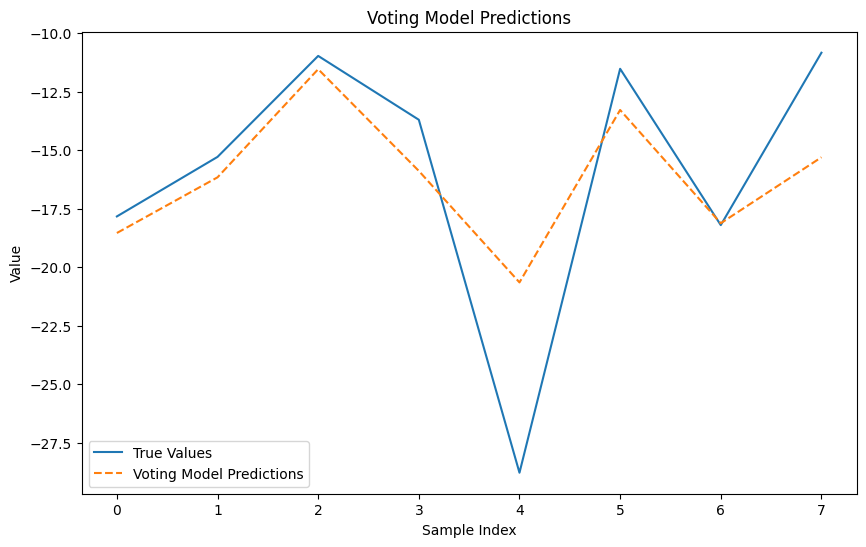

Voting model saved to voting_model.pkl
Loaded Voting model R2 score: 0.6166723809734227
Loaded Voting model MSE: 11.956095647885022
Loaded Voting model RMSE: 3.4577587607994027
Loaded Voting model MAE: 2.3479123468375493


In [2]:
# define VotingRegressor
voting_model = VotingRegressor(estimators=[
    ('elastic_net', elastic_net),
    ('gbr', gbr)
])

# train VotingRegressor
voting_model.fit(X_meta_train, y_train)

# evaluate VotingRegressor
y_pred_voting = voting_model.predict(X_meta_test)

r2_voting = r2_score(y_test, y_pred_voting)
mse_voting = mean_squared_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mse_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)

print(f'Voting Model - R2 score: {r2_voting}')
print(f'Voting Model - MSE: {mse_voting}')
print(f'Voting Model - RMSE: {rmse_voting}')
print(f'Voting Model - MAE: {mae_voting}')

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_voting, label='Voting Model Predictions', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Voting Model Predictions')
plt.legend()
plt.show()

# save VotingRegressor model
joblib_file = "voting_model.pkl"
joblib.dump(voting_model, joblib_file)
print(f"Voting model saved to {joblib_file}")

# load VotingRegressor model
loaded_voting_model = joblib.load(joblib_file)
loaded_y_pred = loaded_voting_model.predict(X_meta_test)

loaded_r2 = r2_score(y_test, loaded_y_pred)
loaded_mse = mean_squared_error(y_test, loaded_y_pred)
loaded_rmse = np.sqrt(loaded_mse)
loaded_mae = mean_absolute_error(y_test, loaded_y_pred)

print(f'Loaded Voting model R2 score: {loaded_r2}')
print(f'Loaded Voting model MSE: {loaded_mse}')
print(f'Loaded Voting model RMSE: {loaded_rmse}')
print(f'Loaded Voting model MAE: {loaded_mae}')

weight: [0.06115385 0.95349231]
Weighted Average Model - R2 score: 0.49902952120245914
Weighted Average Model - MSE: 15.625409346919174
Weighted Average Model - RMSE: 3.9528988536160616
Weighted Average Model - MAE: 2.958602267281974


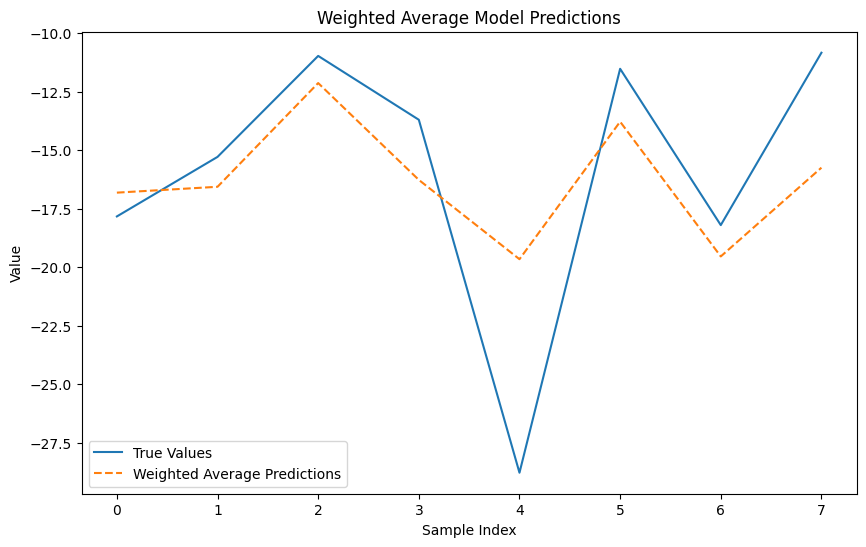

Model saved to weighted_average_model_predictions.pkl
Loaded Weighted Average Model R2 score: 0.49902952120245914
Loaded Weighted Average Model MSE: 15.625409346919174
Loaded Weighted Average Model RMSE: 3.9528988536160616
Loaded Weighted Average Model MAE: 2.958602267281974


In [3]:
y_pred_elastic_net_train = elastic_net.predict(X1_train)
y_pred_gbr_train = gbr.predict(X2_train)

y_pred_elastic_net_test = elastic_net.predict(X1_test)
y_pred_gbr_test = gbr.predict(X2_test)

meta_features_train = np.column_stack((y_pred_elastic_net_train, y_pred_gbr_train))
meta_features_test = np.column_stack((y_pred_elastic_net_test, y_pred_gbr_test))

linear_reg = LinearRegression()
linear_reg.fit(meta_features_train, y_train)

weights = linear_reg.coef_
print(f"weight: {weights}")

y_pred_train = weights[0] * y_pred_elastic_net_train + weights[1] * y_pred_gbr_train
y_pred_test = weights[0] * y_pred_elastic_net_test + weights[1] * y_pred_gbr_test

r2_weighted = r2_score(y_test, y_pred_test)
mse_weighted = mean_squared_error(y_test, y_pred_test)
rmse_weighted = np.sqrt(mse_weighted)
mae_weighted = mean_absolute_error(y_test, y_pred_test)

print(f'Weighted Average Model - R2 score: {r2_weighted}')
print(f'Weighted Average Model - MSE: {mse_weighted}')
print(f'Weighted Average Model - RMSE: {rmse_weighted}')
print(f'Weighted Average Model - MAE: {mae_weighted}')

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_test, label='Weighted Average Predictions', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Weighted Average Model Predictions')
plt.legend()
plt.show()

joblib_file = "weighted_average_model_predictions.pkl"
joblib.dump((y_pred_train, y_pred_test), joblib_file)
print(f"Model saved to {joblib_file}")

loaded_y_pred_train, loaded_y_pred_test = joblib.load(joblib_file)

loaded_r2 = r2_score(y_test, loaded_y_pred_test)
loaded_mse = mean_squared_error(y_test, loaded_y_pred_test)
loaded_rmse = np.sqrt(loaded_mse)
loaded_mae = mean_absolute_error(y_test, loaded_y_pred_test)

print(f'Loaded Weighted Average Model R2 score: {loaded_r2}')
print(f'Loaded Weighted Average Model MSE: {loaded_mse}')
print(f'Loaded Weighted Average Model RMSE: {loaded_rmse}')
print(f'Loaded Weighted Average Model MAE: {loaded_mae}')